# Fashion MNIST Image Classification
---

## Import Libraries

In [ ]:
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, roc_curve, auc

from sklearn.decomposition import PCA


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Prepare Data

- convert ubyte to a dataframe/csv.

In [8]:
def read_ubyte(fp_img, fp_lbl, fp_out=None):
	l= []
	with gzip.open(fp_lbl, 'rb') as f:
		f.read(8)
		l= [[x] for x in f.read()]
	
	with gzip.open(fp_img, 'rb') as f:
		f.read(16)
		for i in range(len(l)):
			l[i].extend([c for c in f.read(28*28)])

	if fp_out is not None:
		with open(fp_out, 'w') as f:
			f.write(','.join(['label']+[f'{i}' for i in range(28*28)])+'\n')
			for row in l:
				f.write(','.join(str(col) for col in row)+'\n')
	
	return pd.DataFrame(l, columns=['label']+[i for i in range(28*28)])


## Load Data

- load dataframe.
- check for missing values.
- check for duplicated rows.

In [9]:
df_trn= read_ubyte('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')

In [10]:
print('duplicated rows: ', df_trn.duplicated().sum())
print('missing values:  ', df_trn.isna().sum().sum())

duplicated rows:  0
missing values:   0


In [11]:
df_tst= read_ubyte('t10k-images-idx3-ubyte.gz',  't10k-labels-idx1-ubyte.gz')

In [12]:
print('duplicated rows: ', df_tst.duplicated().sum())
print('missing values:  ', df_tst.isna().sum().sum())

duplicated rows:  0
missing values:   0


In [13]:
df_trn['label'].sort_values().unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [14]:
df_tst['label'].sort_values().unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

select 5 classses

In [15]:
df_trn= df_trn[df_trn['label']<5]

In [16]:
df_tst= df_tst[df_tst['label']<5]

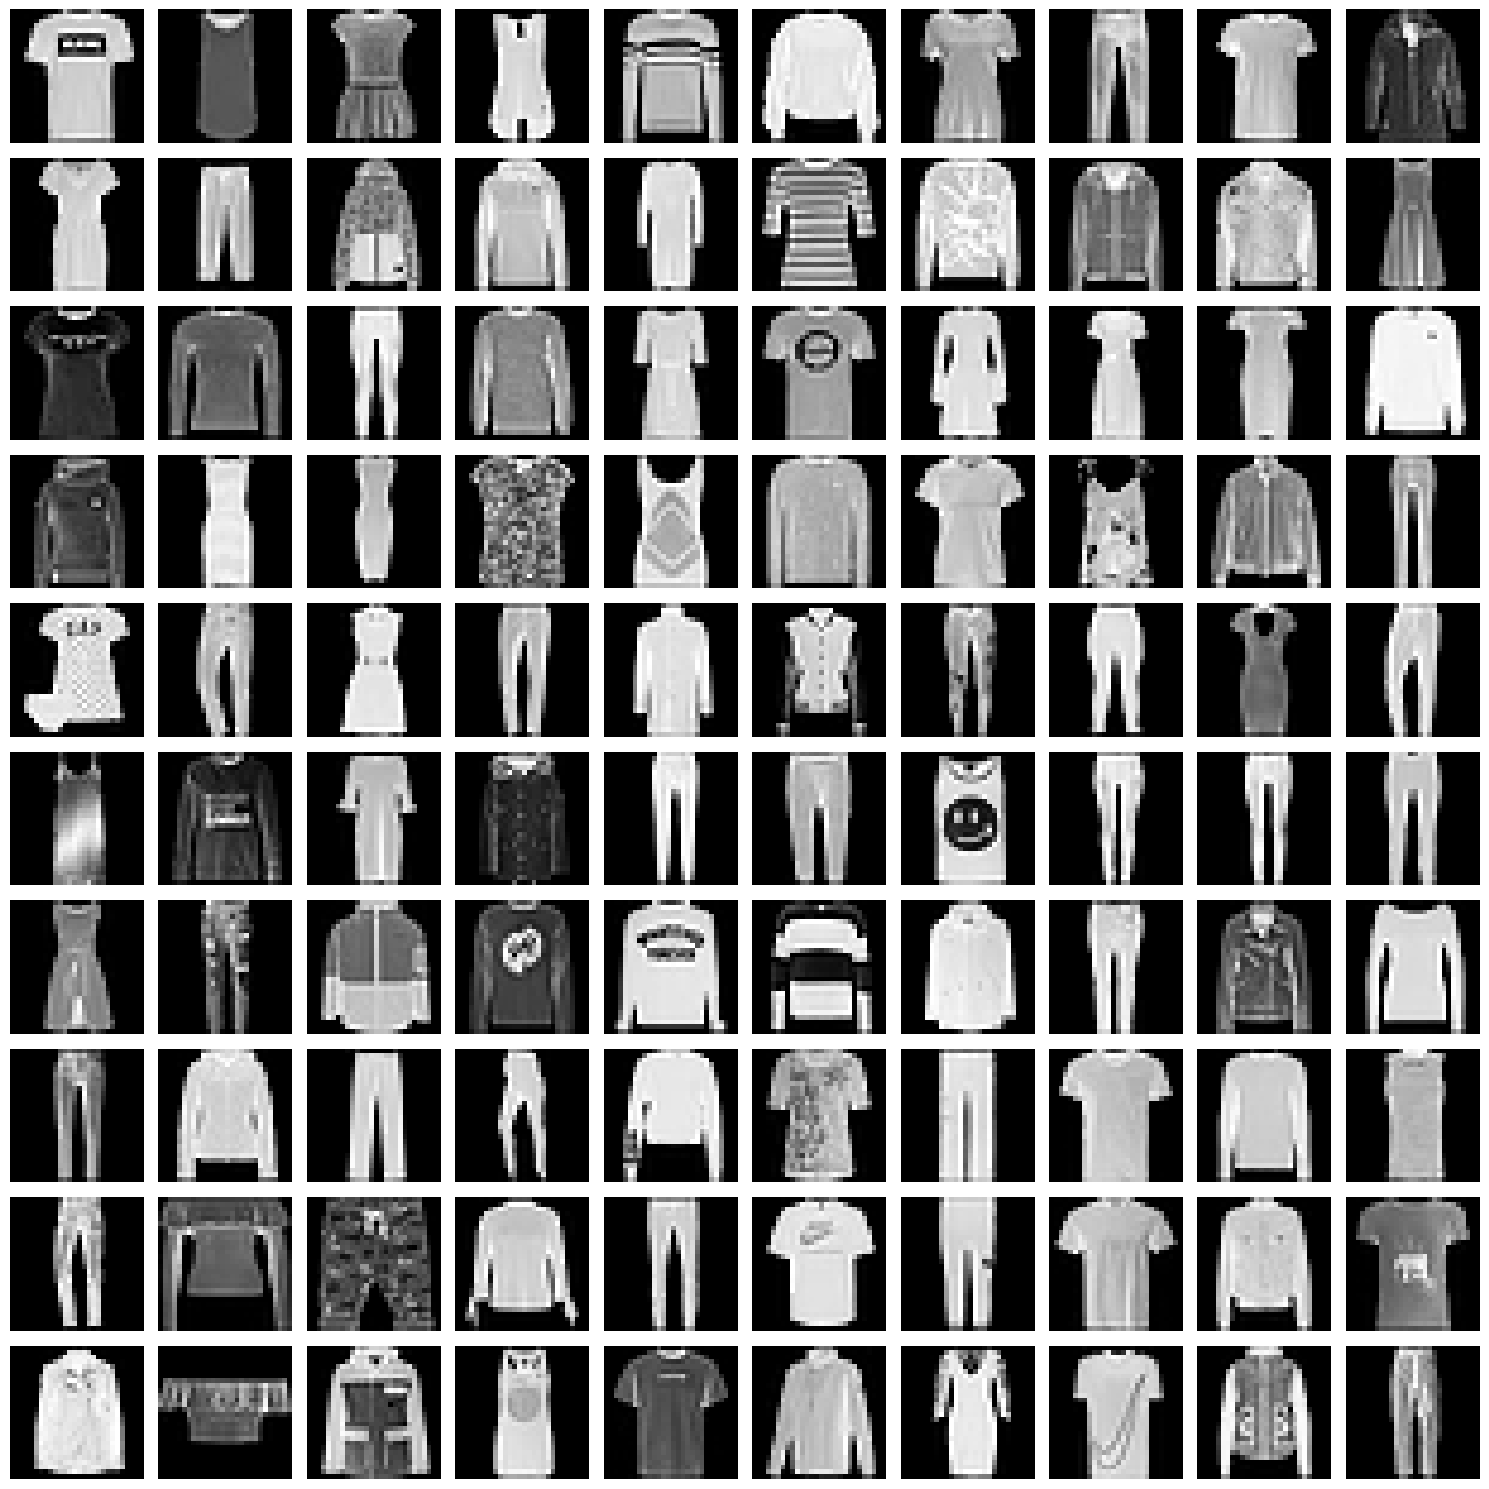

In [15]:
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.array(df_trn.iloc[i, 1:]).reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Data Preprocessing

### Feature Extraction
- select 5 classes

In [17]:
X_trn= df_trn.drop('label', axis=1)
y_trn= df_trn['label']

X_tst= df_tst.drop('label', axis=1)
y_tst= df_tst['label']

### Scaling

In [18]:
scaler= StandardScaler()

In [19]:
X_trn= scaler.fit_transform(X_trn)
X_tst= scaler.transform(X_tst)

### PCA

Explained variance ratio: [0.22443032 0.12820831 0.06843521 0.05258439 0.03252352 0.02862473
 0.02232024 0.01757826 0.01489521 0.01363353 0.0123006  0.01113677
 0.01075531 0.00912747 0.00881179 0.00828745 0.00799243 0.00760252
 0.00709583 0.00691866 0.00649498 0.00626207 0.00577898 0.00566795
 0.0054525  0.0051639  0.0048422  0.00469543 0.00460407 0.00440807
 0.00429932 0.00408979 0.00397453 0.00389897 0.00377681 0.00365183
 0.00358229 0.00347631 0.00331432 0.00319921 0.00314154 0.00307577
 0.0029748  0.0029527  0.00282391 0.00269262 0.0026651  0.00262422
 0.00257939 0.00254105]


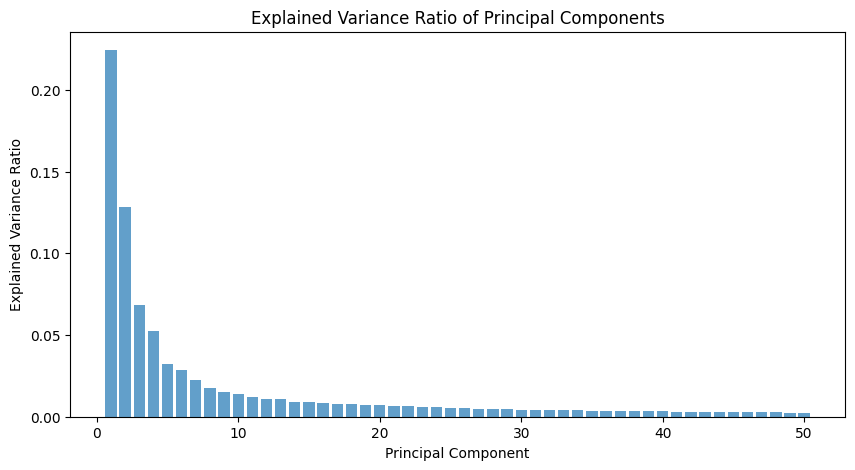

In [ ]:
# Initialize PCA with the number of components you want to keep
pca = PCA(n_components=50)

# Fit and transform the training data
X_trn_pca = pca.fit_transform(X_trn)

# Transform the test data
X_tst_pca = pca.transform(X_tst)

# Print the explained variance ratio to see how much variance is captured by each component
print("Explained variance ratio:", pca.explained_variance_ratio_)
plt.figure(figsize=(10, 5))
plt.bar(range(1, 51), pca.explained_variance_ratio_, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.show()

## Model Training

In [20]:
def model_evaluate(model):
	pred= model.predict(X_tst)
	print('Train Accuracy:  ', accuracy_score(y_trn, model.predict(X_trn)))
	print('Test Accuracy:   ', accuracy_score(y_tst, pred))
	print('Precision Score: ', precision_score(y_tst, pred, average='macro'))
	print('Recall Score:    ', recall_score(y_tst, pred, average='macro'))
	print('Classification Report\n', classification_report(y_tst, pred))
	ConfusionMatrixDisplay(confusion_matrix(y_tst, pred)).plot()
	plt.show()

In [21]:
def model_roc(model):
	fpr= {}
	tpr= {}
	roc_auc= {}

	# plt.figure(figsize=(12, 8))
	for i in range(len(y_tst.unique())):
		fpr[i], tpr[i], _= roc_curve(y_tst==i, model.predict_proba(X_tst)[:,i])
		roc_auc[i]= auc(fpr[i], tpr[i])
		plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
	plt.plot([0, 1], [0, 1], 'k--')
	plt.xlim([0.0, 1.0])
	plt.ylim([0.0, 1.05])
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	plt.title('Receiver Operating Characteristic (ROC) Curve')
	plt.legend(loc='lower right')
	plt.tight_layout()
	plt.show()

### Logistic Regression

In [22]:
lr= LogisticRegression(max_iter=10000, solver='lbfgs', warm_start=True)

In [23]:
lr.fit(X_trn, y_trn)

LogisticRegression(max_iter=10000, warm_start=True)

Train Accuracy:   0.9193
Test Accuracy:    0.8608
Precision Score:  0.8610818023626219
Recall Score:     0.8608
Classification Report
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      1000
           1       0.96      0.95      0.96      1000
           2       0.80      0.79      0.80      1000
           3       0.84      0.85      0.85      1000
           4       0.81      0.82      0.81      1000

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



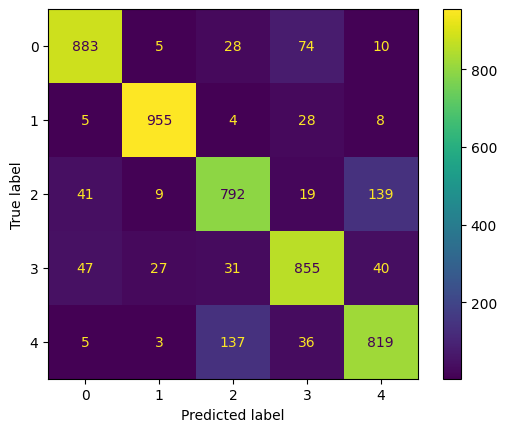

In [24]:
model_evaluate(lr)

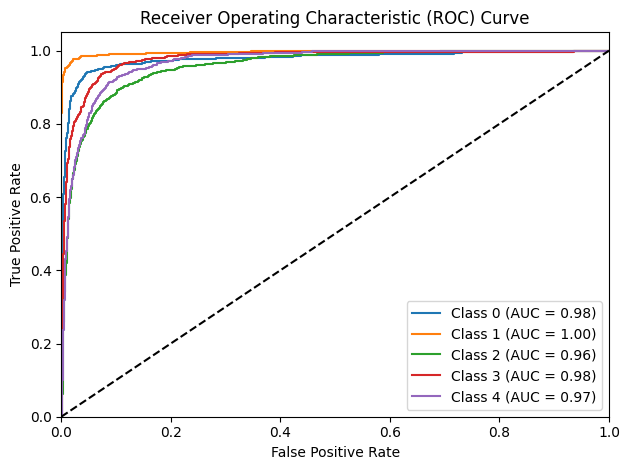

In [25]:
model_roc(lr)

### KNNClassifier

In [26]:
knn= KNeighborsClassifier()

In [27]:
knn.fit(X_trn, y_trn)

KNeighborsClassifier()

Train Accuracy:   0.9285666666666667
Test Accuracy:    0.8886
Precision Score:  0.8898070419519328
Recall Score:     0.8886000000000001
Classification Report
               precision    recall  f1-score   support

           0       0.90      0.93      0.92      1000
           1       0.99      0.96      0.98      1000
           2       0.81      0.84      0.82      1000
           3       0.92      0.88      0.90      1000
           4       0.83      0.82      0.83      1000

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



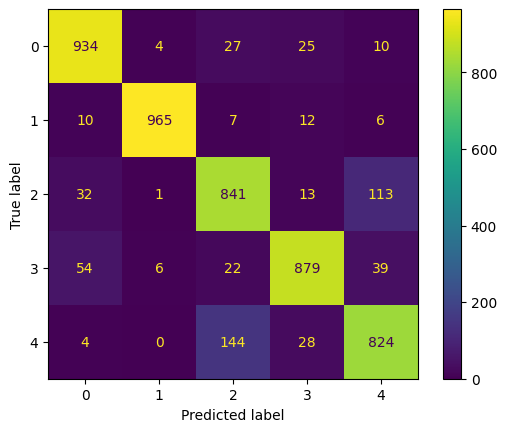

In [28]:
model_evaluate(knn)

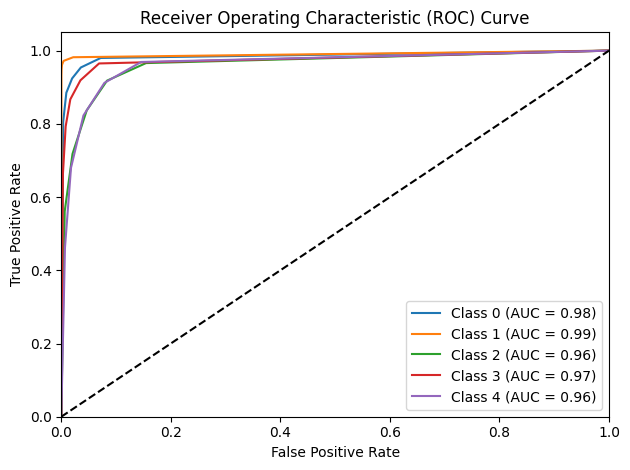

In [29]:
model_roc(knn)

## Use Tensorflow for loss curve

/home/baheg/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-06 11:01:40.307919: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


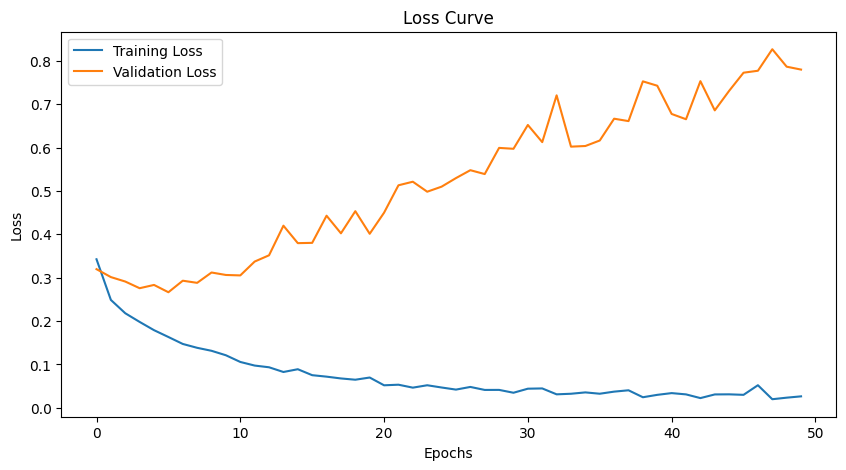

In [30]:
# Define the model
model = Sequential()
model.add(Dense(128, input_dim=X_trn.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model and store the history
history = model.fit(X_trn, y_trn, epochs=50, validation_data=(X_tst, y_tst), verbose=0)

# Plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Other Models

In [ ]:
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from lightgbm import LGBMClassifier

In [ ]:
# def model_report(model, verbose=True):
# 	model.fit(X_trn, y_trn)

# 	y_pred=   model.predict(X_tst)
# 	trnScore= model.score(X_trn, y_trn)
# 	tstScore= model.score(X_tst, y_tst)
# 	accScore= accuracy_score(y_tst, y_pred)
# 	preScore= precision_score(y_tst, y_pred, average='macro')
# 	recScore= recall_score(y_tst, y_pred, average='macro')
# 	cm= confusion_matrix(y_tst, y_pred)

# 	if verbose:
# 		print('Train Score: %f'%trnScore)
# 		print('Test Score:  %f'%tstScore)
# 		print('Accuracy Score: %f'%accScore)
# 		print('Precision Score: %f'%preScore)
# 		print('Recall Score: %f'%recScore)

# 		ConfusionMatrixDisplay(cm).plot()
# 		plt.show()
# 		print()
	
# 	return {
# 		'trn':  trnScore,
# 		'tst':  tstScore,
# 		'acc':  accScore,
# 		'pre':  preScore,
# 		'rec':  recScore,
# 		'cm':   cm,
# 	}

In [ ]:
# models_dict= {
# 	'LogisticRegression':        LogisticRegression(max_iter=10_000, solver='lbfgs'),
# 	'KNeighborsClassifier':      KNeighborsClassifier(),
# 	'Support Vector Classifier': SVC(),
# 	'DecisionTreeClassifier':    DecisionTreeClassifier(),
# 	'RandomForestClassifier':    RandomForestClassifier(),
# 	'BaggingClassifier':         BaggingClassifier(),
# 	'ExtraTreesClassifier':      ExtraTreesClassifier(),
# 	'AdaBoostClassifier':        AdaBoostClassifier(),
# 	# 'XGBClassifier':             XGBClassifier(),
# 	# 'CatBoostClassifier':        CatBoostClassifier(verbose=False),
# 	# 'LGBMClassifier':            LGBMClassifier(),
# }
# models= [{'name':k, 'obj':v} for k,v in models_dict.items()]

# i= 0
# for model in models:
# 	print("Evaluating %s..."%model['name'])
# 	print("%d/%d models"%(i, len(models)), end='\r')
# 	model.update(model_report(model['obj'], verbose=False))
# 	i+= 1
# print("%d/%d models evaluated"%(i, len(models)))
# print("done")

In [ ]:
# pd.DataFrame({
# 	'Algorithm':           [model['name'] for model in models],
# 	'Train Score':         [model['trn']  for model in models],
# 	'Test Score':          [model['tst']  for model in models],
# 	'Accuracy Score':      [model['acc']  for model in models],
# 	'Precision Score':     [model['pre']  for model in models],
# 	'Recall Score':        [model['rec']  for model in models],
# }).set_index('Algorithm').sort_values(by='Test Score', ascending=False)


## Conclusion